63f78014766fd30436c18a79_Hyperspace - navbar logo.png


# Image and Text Search Using Hyperspace
This notebook illustrates the application of Hyperspace multi-vector search for both image and text search. The queries will integrate lexical search with multi-vector search techniques, leveraging embedded text and image data.

The vectors were embedded using the [Clip ViT-B/32](https://github.com/openai/CLIP) model 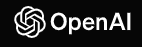

This notebook was created in collaboration with [argmax](https://www.linkedin.com/company/argmax/?originalSubdomain=il).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/ImageAndTextSearch/ImageAndTextSearch.ipynb)

# The Dataset - Amazaon Catalogue 2020
The dataset includes 100,000 documents from the amazon 2020 product catalogue. Exh document include the following fields:

*   **id** [float] - unique identifier per product
*   **amznid** [keyword] - unique identifier by Amazon, per product
*   **title** [keyword] - the product title
*   **img_link** [keyword] - url to the product image
*   **img_clip** list[[float]] - embedding of the product image
*   **txt_clip** list[[float]] - embedding of the product description

The embedded vectors are of dimension 512.

The data can be downloaded from the following links: [text embedding](http://hyperspace-datasets.s3.amazonaws.com/text_clip_emb.npy), [image embedding](http://hyperspace-datasets.s3.amazonaws.com/img_clip_emb.npy)

# Load the Data

In [1]:
import numpy as np
import pandas as pd

collection_name = 'amazon-images-norm'
embedding_path = "img_clip_emb.npy"
text_clip_emb_path = "text_clip_emb.npy"
product_images_path = "product_images.parquet"

img_vecs = np.load(embedding_path)
text_vecs = np.load(text_clip_emb_path)
metadata = pd.read_parquet(product_images_path)


# Create Keywords
We will tokenize the title to create keyword fields, to be used in the search. We use nltk and regex

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english') + [r'/', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
tokenizer = RegexpTokenizer(r'\w+')


def normalize_text(text):
    keywords = list(set(tokenizer.tokenize(text)) - set(stopwords))
    return keywords


metadata["keywords"] = metadata["title"].apply(lambda x: normalize_text(x))

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TamirBracha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TamirBracha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Setting up the Hyperspace environment
Working with Hyperspace requires the followin steps

1. Install the client API
2. Create data config file
3. Connect to a server
4. Create collection
5. Ingest data
6. Run query

## 1. Install the client API
Hyperspace API can be installed directly from git, using the following command

In [3]:
pip install git+https://github.com/hyper-space-io/hyperspace-py

  Cloning https://github.com/hyper-space-io/hyperspace-py to c:\users\tamirbracha\appdata\local\temp\pip-req-build-be1mm7ii
  Resolved https://github.com/hyper-space-io/hyperspace-py to commit c49c83710c5b466a4bb299f7ad70f618d3a6df94
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/hyper-space-io/hyperspace-py 'C:\Users\TamirBracha\AppData\Local\Temp\pip-req-build-be1mm7ii'
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Download dataset

In [4]:
from urllib.request import urlretrieve
import os

def download_data(url, file_name):
    """
    url (str): URL of the file to download.
    file_name (str): Local path where the file will be saved.
    """
    # Check if the file already exists and is not empty
    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
        print(f"The file {file_name} already exists and is not empty.")
    else:
        try:
            # Attempt to download the file from `url` and save it locally under `file_name`
            urlretrieve(url, file_name)
            # Check if the file was downloaded and is not empty
            if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                print(f"Successfully downloaded {file_name}")
            else:
                print("Download failed or file is empty.")
                
        except Exception as e:
            print(f"An error occurred: {e}")

In [6]:
text_embedding_url = "http://hyperspace-datasets.s3.amazonaws.com/text_clip_emb.npy"
image_embedding_url = "http://hyperspace-datasets.s3.amazonaws.com/img_clip_emb.npy"
download_data(text_embedding_url, "./text_clip_emb.npy")
download_data(image_embedding_url, "./img_clip_emb.npy")

Successfully downloaded ./text_clip_emb.npy
Successfully downloaded ./img_clip_emb.npy


#2. Connect to a server

Once the Hyperspace API is installed, the database can be accessed by creating a local instance of the Hyperspace client. This step requires host address, username and password

In [ ]:
import hyperspace
from getpass import getpass

username = "USERNAME"
host = "HOST_URL"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=getpass())

#3.   Create a Data Schema File

Similarly to other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Here, we create a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" (inner product) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.
Here, we use "brute_force" (exact KNN) with inner product.

In [ ]:
import json

config = {
    "configuration": {
        "id": {
            "type": "keyword",
            "id": True
        },
        "amznid": {
            "type": "keyword"
        },

        "title": {
            "type": "keyword"
        },
        "keywords": {
            "type": "keyword",
            "struct_type": "list"
        },
        "must_include": {
            "type": "keyword",
            "struct_type": "list"
        },

        "img_link": {
            "type": "keyword"
        },
        "img_clip": {
            "type": "dense_vector",
            "dim": 512,
            "index_type": "brute_force",
            "metric": "IP"
        },
        "txt_clip": {
            "type": "dense_vector",
            "dim": 512,
            "index_type": "brute_force",
            "metric": "IP"
        }
    }
}

with open('imagesearch_config.json', 'w') as f:
    f.write(json.dumps(config, indent=2))

## 4. Create Collection
Hyperspace stores data in Collections, where each collections, that are sub repositories in the cloud. Each search then operates within a specific collection. To create a collection, use the command **"create_collection(schema_filename, collection_name)"**.







In [ ]:
collection_name = 'amazon-images-norm'

if collection_name not in hyperspace_client.collections_info()['collections']:
    hyperspace_client.create_collection('imagesearch_config.json', collection_name)

hyperspace_client.collections_info()

## 5. Ingest data

In the next step we ingest the dataset to the Hyperspace database in batches of 500 documents. The batch size can be controlled by user, and in particular, can be increased in order decrease ingestion time. You can batches of data using the command **add_batch(batch, collection_name)**.
If no Id per document is provided, Hyperspace will randomly assign one.

Here, we will assign id values to each documents by adding an "id" field to the data. If the id field is decalred in the data schema config file, this step is mandatory.

In [ ]:
metadata["id"] = range(0, metadata.shape[0])
metadata["id"] = metadata["id"].apply(lambda x: str(x))

In [ ]:
import math

BATCH_SIZE = 500


def normalize_euclidean_norm(input_list):
    if abs(sum(input_list)) < 0.0000000000000001:
        return input_list
    euclidean_norm = math.sqrt(sum(x ** 2 for x in input_list))
    if euclidean_norm == 0:
        return input_list
    normalized_list = [x / euclidean_norm for x in input_list]
    return normalized_list


batch = []

for i, ((_, metadata_row), img_vec, text_vec) in enumerate(zip(metadata.iterrows(), img_vecs, text_vecs)):
    row = {}
    row['id'] = metadata_row["id"]
    row['amznid'] = metadata_row['asin']
    row['keywords'] = metadata_row['keywords']
    row['title'] = metadata_row['title']
    row['img_link'] = metadata_row['primary_image']
    row['img_clip'] = normalize_euclidean_norm(np.ndarray.tolist(img_vec))
    row['txt_clip'] = normalize_euclidean_norm(np.ndarray.tolist(text_vec))

    batch.append(row)

    if i % BATCH_SIZE == 0:
        try:
            response = hyperspace_client.add_batch(batch, collection_name)
        except:
            display(batch)
            break
        batch.clear()
        print(i, response)
response = hyperspace_client.add_batch(batch, collection_name)
batch.clear()
print(i, response)
hyperspace_client.commit(collection_name)

We check the collection status before we continue

In [ ]:
hyperspace_client.collections_info()

## 6. Running The Query
We will perfome the following query types


1.   Vector search with a single vector
2.   Vector search with two vectors
3.   Hybrid search


We will select a document from the database and use Hyperspace similarity search to find similar ones.

In [ ]:
from PIL import Image
import requests

collection_name = 'amazon-images-norm'

test_id = 3801
input_document = hyperspace_client.get_document(collection_name, test_id)
print(input_document['title'])
img = Image.open(requests.get(input_document['img_link'], stream=True).raw)
img.resize((125, 150))

### 1. Vector Search Query
We start with a single document similarity search, based on **image embedding**. We provide the input document under the "params" key in the query.

In [ ]:
results = hyperspace_client.search(
    {'params': {'img_clip': input_document['img_clip']}, 'knn': [{'field': 'img_clip', "boost": 1}]},
    size=10,
    collection_name=collection_name)

for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))

We see that results are generally relevant, but mostly return the same product with different size. Let us repeat the process with **embedded text**.

In [ ]:
results = hyperspace_client.search(
    {'params': {'txt_clip': input_document['txt_clip']}, 'knn': [{'field': 'txt_clip', "boost": 1}]},
    size=10,
    collection_name=collection_name)

print("Query took " + str(results["took_ms"]) + "[ms]\n")

for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))

The items deviate more significantly than before, particularly in magnitudes such as size and brand team, suggesting a potential association with irrelevant products.Note that the first items in bothe seacrh methdos are idenctical, as they share the same image and nearly identical text description.

### 2. Multi Vector search
Hyperspace supports the use of multiple documents in a single query. We use this ability to combine image and text search. Results are union of the two spaces.

In [ ]:
results = hyperspace_client.search({'params': {'img_clip': input_document['img_clip'],
                                               'txt_clip': input_document['txt_clip']},
                                    'knn': [{'field': 'img_clip', "boost": 0.5}, {'field': 'txt_clip', "boost": 0.5}]},
                                   size=10,
                                   collection_name=collection_name)

for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))


Results combine the embedded image vector search the embedded text vector search. Yet, many results are still duplicates with less relevant properties.

### 3. Hybrid Search Query
Let us now use the keywords to improve the search results. We will first set the score function, which returns the sum of TF-IDF scores of all matched keywords. We will set shoe size and brand team. The first step is to set the score function, see example below:

In [ ]:
import inspect


def set_score_function(func, collection_name, score_function_name='func'):
    source = inspect.getsource(func)
    with open('sf.py', 'w') as f:
        f.write(source)
    hyperspace_client.set_function('sf.py', collection_name, score_function_name)

In [ ]:

def keyword_matching(Q, V):
    score = 0
    if match('keywords'):
        score = rarity_sum('keywords')
    return knn_filter('img_clip', min_score=0.01) * score


set_score_function(keyword_matching, collection_name, score_function_name='keyword_matching')

You can set weights for each query component using the "boost" key. We will use this capability to adjust the weights in the Hybrid query

In [ ]:
document = input_document
document["keywords"] = ["XL", "Chicago"]

query = {
    'params': document,
    'knn': [{'field': 'img_clip'},
            {'field': 'txt_clip'},
            {'field': 'query'}]
}
print("Query took " + str(results["took_ms"]) + "[ms]\n")

results = hyperspace_client.search(query,
                                   size=10,
                                   function_name='keyword_matching',
                                   collection_name=collection_name)
for res in results['similarity']:
    print(f"{res['document_id']}, score = {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))


In [ ]:
document = input_document
document["keywords"] = ["XL", "Chicago"]

query = {
    'params': document
}

results = hyperspace_client.search(query,
                                   size=10,
                                   function_name='keyword_matching',
                                   collection_name=collection_name)
print("Query took " + str(results["took_ms"]) + "[ms]\n")
for res in results['similarity']:
    print(f"{res['document_id']}, score = {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))


We can see that the hybrid search improved the results, by only returning the correct size and brand, while still providing a variety of results.

# General user query
In the subsequent step, we load the CLIP model and use it to generate embeddings from a custom query text. We first install the necessary packages.

In [ ]:
!pip install clip

In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install transformers

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')


## Query Text Embedding

Now that the model is loaded, we can embed a free text and run a query

In [ ]:
input_text = ["Chicago Bears Flip Flops"]
text_vec = [float(x) for x in list(model.encode(input_text)[0])]

query = {
    'params': document,
    'knn': [{'field': 'txt_clip', "boost": 1},
            {'field': 'query', "boost": 0.2}]
}

results = hyperspace_client.search(query,
                                   size=10,
                                   collection_name=collection_name)

print("Query took " + str(results["took_ms"]) + "[ms]\n")

for res in results['similarity']:
    print(f"{res['document_id']}, score = {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))

In [ ]:
input_text = ["Chicago Bears Slides in XL size"]

document["txt_clip"] = [float(x) for x in list(model.encode(input_text)[0])]
document["keywords"] = input_text[0].split(" ")

query = {
    'params': document,
    'knn': [{'field': 'txt_clip'},
            {'field': 'query'}]
}

results = hyperspace_client.search(query,
                                   size=10,
                                   function_name='keyword_matching',
                                   collection_name=collection_name)

for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['title'])
    img = Image.open(requests.get(result['img_link'], stream=True).raw)
    display(img.resize((125, 150)))

The text embeddding match results appear to be quite irrelevant

This notebook gave a simple example of the use of the Hyperspace engine. Hyperspace supports signficantly more complicated use cases with large databases, in extremley low latency.
For more information, visit us at [Hyperspace](https://www.hyper-space.io/)